# 프로젝트 개요
- 강의명 : (산대특)_공공데이터 활용 빅데이터 분석 및 시각화 전문가 과정 육성
- 교과목명 : 빅데이터 기반 딥러닝
- 프로젝트 주제 : CNN 알고리즘을 활용하여 개와 고양이를 구분하는 딥러닝 코드를 작성한다. 
- 프로젝트 마감일 : 2022년 11월 04일 금요일
- 수강생명 : 황지훈

---

## Step 1. 구글 드라이브 연동 및 파일 확인

- 한글 서체 설치

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,460 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

### 구글 드라이브 연동

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 경로 설정

In [6]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/산대특/961027hjh/catanddog'
train_dir = DATA_PATH + '/train/'
valid_dir = DATA_PATH + '/validation/'

### 데이터 확인

In [46]:
import glob

images = glob.glob(train_dir + 'Cat/*.jpg')

del images[4:]
images

['/content/drive/MyDrive/Colab Notebooks/산대특/961027hjh/catanddog/train/Cat/14.jpg',
 '/content/drive/MyDrive/Colab Notebooks/산대특/961027hjh/catanddog/train/Cat/11.jpg',
 '/content/drive/MyDrive/Colab Notebooks/산대특/961027hjh/catanddog/train/Cat/10.jpg',
 '/content/drive/MyDrive/Colab Notebooks/산대특/961027hjh/catanddog/train/Cat/1.jpg']

---

## Step2. 이미지 데이터 시각화

### 2 x 2 배열로 시각화

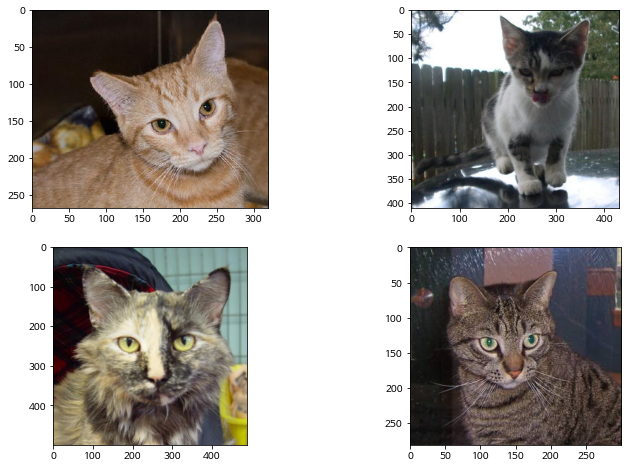

In [72]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

fig = plt.figure(figsize=(12,8))

for i in range(4):
  ax = fig.add_subplot(2,2,i+1)
  ax.imshow(cv2.imread(images[i], cv2.IMREAD_COLOR)[:,:,::-1])

plt.show()

---
## Step3. 사전 훈련된 모델 내려받기

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPool2D, GlobalAveragePooling2D

model = ResNet50(include_top = True,
                 weights='imagenet', # imagenet 에 사용된 가중치
                 input_tensor=None,
                 input_shape=None,
                 pooling=None,
                 classes=1000)

In [20]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

---

## Step4. 네트워크에 밀집층 추가

### 밀집층 추가

In [24]:
model.trainable = False

model = Sequential([model, Dense(2, activation = 'sigmoid')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_2 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25,638,714
Trainable params: 2,002
Non-trainable params: 25,636,712
_________________________________________________________________


---

## Step5. 훈련에 사용될 환경 설정

### 모델 컴파일

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

---

## Step6. 이미지 데이터 증강

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 224
image_width = 224

train = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

train_generator = train.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                    )

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


---

## Step7. 모형 학습, 모형 정확도 시각화, 예측

### 모형 학습

In [31]:
history=model.fit(train_generator,
          epochs=5,
          validation_data=valid_generator,
          verbose=2)

Epoch 1/5
13/13 - 106s - loss: 0.6931 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000 - 106s/epoch - 8s/step
Epoch 2/5
13/13 - 8s - loss: 0.6931 - accuracy: 0.5247 - val_loss: 0.6931 - val_accuracy: 0.5816 - 8s/epoch - 596ms/step
Epoch 3/5
13/13 - 8s - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5000 - 8s/epoch - 586ms/step
Epoch 4/5
13/13 - 6s - loss: 0.6932 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.5000 - 6s/epoch - 489ms/step
Epoch 5/5
13/13 - 6s - loss: 0.6930 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000 - 6s/epoch - 494ms/step


## 모델 정확도 시각화

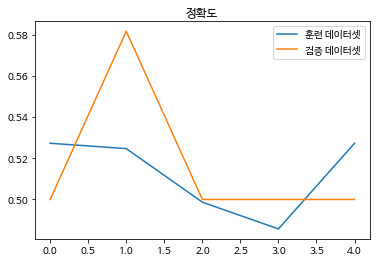

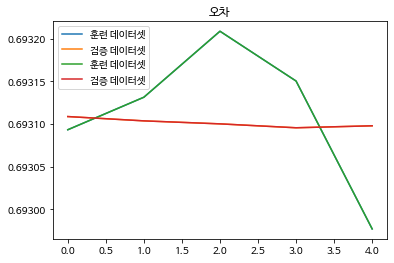

In [32]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, label="훈련 데이터셋")
plt.plot(epochs, val_accuracy, label="검증 데이터셋")
plt.legend()
plt.title('정확도')
plt.figure()


plt.plot(epochs, loss, label="훈련 데이터셋")
plt.plot(epochs, val_loss, label="검증 데이터셋")
plt.legend()
plt.title('오차')


plt.plot(epochs, loss, label="훈련 데이터셋")
plt.plot(epochs, val_loss, label="검증 데이터셋")
plt.legend()
plt.title('오차')
plt.show()

### 훈련된 모델 예측

1/1 [==============================] - 2s 2s/step


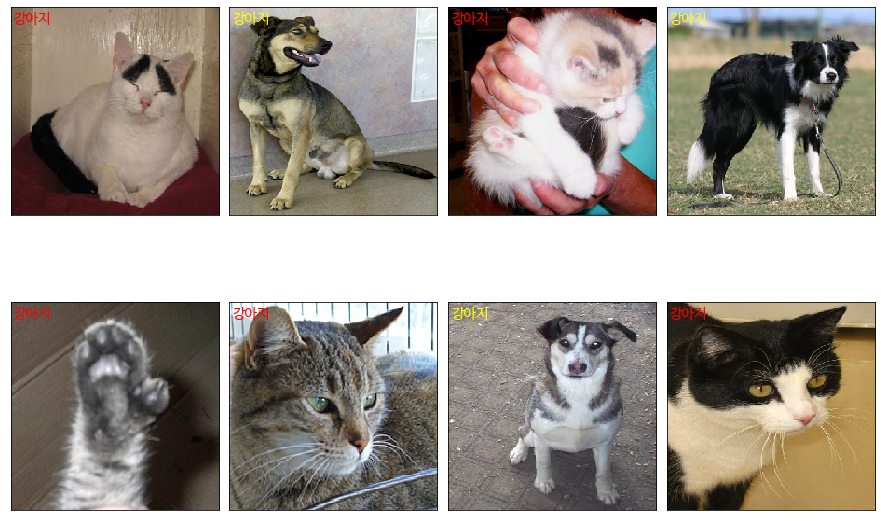

In [33]:
class_names = ['고양이', '강아지']
validation, label_batch  = next(iter(valid_generator))
prediction_values = model.predict(validation)
prediction_values = np.argmax(prediction_values, axis=1)

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(validation[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[prediction_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)